# 1 Compressed Sensing using Deep Decoders

## 1.1 Importing libraries

In [3]:
from __future__ import print_function
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')
from include import *
from PIL import Image
import PIL
import pywt
import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
from sklearn import linear_model

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
    device = 'cuda'
    if torch.cuda.device_count()==0:
        dtype = torch.FloatTensor
        device = 'cpu'
else:
    dtype = torch.FloatTensor
    device = 'cpu'
from scipy.fftpack import dct
from scipy.fftpack import idct
from scipy import io as sio 
import time

num GPUs 0


## 1.2. Loading image and preprocessing

In [4]:
#dataset = 'mnist' # 'mnist' or 'celeba'
dataset = 'celeba'
path = './test_data/' + dataset + '/' 
img_name = dataset + '1' # 1-5 (for celeba), 1-6 (for mnist)
img_path = path + img_name + ".jpg"
img_pil = Image.open(img_path)
if dataset == 'celeba':
    img_pil = img_pil.crop((60,80+20,60+64,80+84)) #crop to 3 x 64 x 64
img_np = pil_to_np(img_pil)
print('Dimensions of input image:', img_np.shape)
img_np = img_np / np.max(img_np)
img_np_orig = 1*img_np

Dimensions of input image: (3, 64, 64)


Display image x and convert to pytorch variable

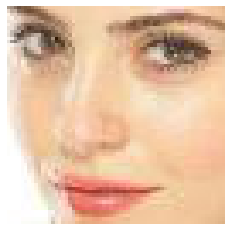

In [5]:
if dataset == 'celeba':
    plt.imshow(img_np.transpose(1,2,0))
else:
    plt.imshow(img_np[0,:,:])
    plt.gray()
plt.axis('off')
img_var = np_to_var(img_np).type(dtype)
d = img_np.shape[1]
out_ch = img_np.shape[0]
d_image = img_np.size

##1.3. Setup model for compressed sensing

In [6]:
f = 0.2 #compression rate
print('Compression rate is ', f)
m_image = int(f*d_image)
print('Number of measurements is ',m_image, ' for signal of length ', d_image)
# random Gaussian measurement matrix : A
Ameas = np.random.randn(m_image,d_image).astype(float)/np.sqrt(m_image)
Ameas_var = torch.from_numpy(Ameas).float().to(device)
# measurements : y = A*x
img_var_meas = torch.matmul(Ameas_var,img_var.to(device).reshape(d_image,1))

Compression rate is  0.2
Number of measurements is  2457  for signal of length  12288


##1.4. Initialize the deep decoder

In [7]:
#use decoder architecture or DC GAN architecture
decodetype = 'upsample' # transposeconv / upsample

if dataset == 'mnist':
    num_channels = [25,15,10] 
elif dataset== 'celeba':    
    num_channels = [120,25,15,10] 
else:
    num_channels = [512,256,128]
    
output_depth = img_np.shape[0] # number of output channels
net = autoencodernet(num_output_channels=output_depth,num_channels_up=num_channels,need_sigmoid=True, Ameas=Ameas_var,
                        decodetype=decodetype
                        ).type(dtype)

print("number of parameters: ", num_param(net))
if decodetype == 'upsample':
    print(net.decoder)
elif decodetype == 'transposeconv':
    print(net.convdecoder)
net_in = copy.deepcopy(net)

n_scales= 4 num_channels_up= [120, 25, 15, 10]
number of parameters:  7920
Sequential(
  (dconv0): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(120, 25, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (drelu0): ReLU()
  (dbn0): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dups0): Upsample(scale_factor=2.0, mode=bilinear)
  (dconv1): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(25, 15, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (drelu1): ReLU()
  (dbn1): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dups1): Upsample(scale_factor=2.0, mode=bilinear)
  (dconv2): Sequential(
    (0): ReflectionPad2d((0, 0, 0, 0))
    (1): Conv2d(15, 10, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (drelu2): ReLU()
  (dbn2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dups2): Upsample(scale_factor=2.0, mode=bilinear)
  (dconv3): 

##1.5 Solving minimization problem to recover the signal

In [13]:
#pick optimization procedure
optim = 'gd'             #'pgd' (projected gradient descent), 'gd' (gradient descent)
if optim == 'pgd':
    optimizer2='SGD'      #outer loop optimizer - 'SGD' (or try 'adam')
    numit = 1000          #number of outer iterations of LS
    LR_LS = 10            #typically 5-10 ; required for outer loop of LS

    OPTIMIZER='SGD'       #inner loop optimizer - SGD or adam
    numit_inner = 10      #number of inner loop iterations for projection
    LR = 0.5             #typically 0.02-0.05 for pgd/inner loop of projection, higher for more complex structures

    lr_decay_epoch = 500  #decay learning rates of both inner and outer optimizers
    
elif optim == 'gd':
    OPTIMIZER='adam'       #optimizer - SGD or adam 
    numit = 10000         #number of iterations for SGD
    LR = 0.0001              #typically 0.02-0.5 for gd , higher for more complex structures

    optimizer2 = None                                    
    numit_inner = None
    LR_LS = None

    lr_decay_epoch = 3000
    
t0 = time.time()
mse_t, ni, net, ni_mod, in_np_img = fit( 
                            net=net,
                            num_channels=num_channels,
                            num_iter=numit,
                            numit_inner = numit_inner,
                            LR=LR,
                            LR_LS = LR_LS,
                            OPTIMIZER = OPTIMIZER,                          
                            optimizer2 = optimizer2,             
                            lr_decay_epoch = lr_decay_epoch,             
                            img_clean_var=img_var_meas,
                            find_best=True,
                            Ameas = Ameas_var,
                            model = 2,
                            code='uniform',
                            decodetype=decodetype,
                            optim=optim,
                            out_channels=out_ch        
                            )
t1 = time.time()
print('\ntime elapsed:',t1-t0)

shape of latent code B1:  [1, 120, 8, 8]
initializing latent code B1...
not optimizing over latent code Z1
optimize decoder with adam 0.0001
optimizing with gradient descent...

LR is set to 0.0001




KeyboardInterrupt: 

Plot loss w.r.t. number of measurements

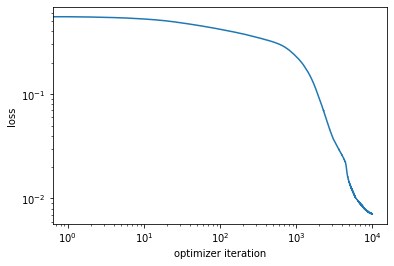

In [14]:
plt.xlabel('optimizer iteration')
plt.ylabel('loss')
plt.loglog(mse_t)

##1.6. Display recovered image

Image inversion with Deep-Decoder, SNR: 16.058563989526316
MSE: 0.041339636


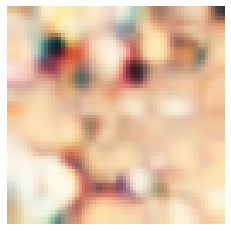

In [15]:
out_img_np = net( ni.type(dtype) ).data.cpu().numpy()[0]

maxv = np.max(img_np) 
print("Image inversion with Deep-Decoder, SNR: " + str(psnr(img_np_orig,out_img_np,maxv)))  
reconstruction_err = mse(img_np_orig,out_img_np,maxv)
print('MSE:',reconstruction_err)
if dataset == 'celeba':
    plt.imshow(out_img_np.transpose(1,2,0))
else:
    plt.imshow(out_img_np[0,:,:])
plt.axis('off')
plt.show()
save_path= optim+'_'+img_name+str(int(10*f))+'.png'
savefig=False
if savefig:
    plt.savefig(save_path,bbox_inches='tight') 